<a href="https://colab.research.google.com/github/yang-song/score_sde_pytorch/blob/main/Score_SDE_demo_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import io
import csv
import numpy as np
#import pandas as pd
import seaborn as sns
import importlib
import os
import functools
import itertools
import torch
from losses import get_optimizer
from models.ema import ExponentialMovingAverage

import torch.nn as nn
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
import tqdm
import io
import likelihood
import controllable_generation
from utils import restore_checkpoint
sns.set(font_scale=2)
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
import cv2

import models
from models import utils as mutils
from models import ncsnv2
from models import ncsnpp
from models import ddpm as ddpm_model
from models import layerspp
from models import layers
from models import normalization

from likelihood import get_likelihood_fn
from sde_lib import VESDE, VPSDE, subVPSDE
from sampling import (ReverseDiffusionPredictor, 
                      LangevinCorrector, 
                      EulerMaruyamaPredictor, 
                      AncestralSamplingPredictor, 
                      NoneCorrector, 
                      NonePredictor,
                      AnnealedLangevinDynamics)
import datasets
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import mean_squared_error as compare_mse
import math
import scipy.io as io

In [2]:
sde = 'VESDE' 
if sde.lower() == 'vesde':
  from configs.ve import SIAT_kdata_ncsnpp_test as configs  
  ckpt_filename = "./exp/checkpoints/checkpoint_7.pth"
  
  print(ckpt_filename)
  if not os.path.exists(ckpt_filename):
      print('!!!!!!!!!!!!!!'+ckpt_filename + ' not exists')
      assert False
  config = configs.get_config()  
  sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
  sampling_eps = 1e-5
  
  
batch_size = 1 #@param {"type":"integer"}
config.training.batch_size = batch_size
config.eval.batch_size = batch_size

random_seed = 0 #@param {"type": "integer"}

sigmas = mutils.get_sigmas(config)
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
score_model = mutils.create_model(config)

optimizer = get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
             model=score_model, ema=ema)

state = restore_checkpoint(ckpt_filename, state, config.device)
ema.copy_to(score_model.parameters())


./exp/checkpoints/checkpoint_7.pth


In [3]:
predictor = ReverseDiffusionPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = LangevinCorrector #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.21  #@param {"type": "number"}
n_steps = 1 #@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}

pc_inpainter = controllable_generation.get_pc_inpainter(sde,
                                                        predictor, corrector,
                                                        inverse_scaler,
                                                        snr=snr,
                                                        n_steps=n_steps,
                                                        probability_flow=probability_flow,
                                                        continuous=config.training.continuous,
                                                        denoise=True)                                                      
                                                        

In [4]:
def make_dsr_rgb(dimg,Nimg,Nfir,data):

    Nshrink=Nimg-Nfir+1;  
    if Nimg%2==0:
        hNimg=int(Nimg/2)
    else:
        hNimg=int((Nimg-1)/2) 


    Ny,Nx,Nc=dimg.shape
     
    arr0 = np.pad(dimg[:,:,0],((hNimg,hNimg),(hNimg,hNimg)),'constant')
    arr1 = np.pad(dimg[:,:,1],((hNimg,hNimg),(hNimg,hNimg)),'constant')
    arr2 = np.pad(dimg[:,:,2],((hNimg,hNimg),(hNimg,hNimg)),'constant')
    
    dimgp = np.concatenate((arr0[:,:,np.newaxis],arr1[:,:,np.newaxis],arr2[:,:,np.newaxis]),2)
    
    arr3 = np.pad(data[:,:,0],((hNimg,hNimg),(hNimg,hNimg)),'constant')
    arr4 = np.pad(data[:,:,1],((hNimg,hNimg),(hNimg,hNimg)),'constant')
    arr5 = np.pad(data[:,:,2],((hNimg,hNimg),(hNimg,hNimg)),'constant')
    
    datap = np.concatenate((arr3[:,:,np.newaxis],arr4[:,:,np.newaxis],arr5[:,:,np.newaxis]),2)

    vmask_arr = np.ones((256,256))
    vmask_arr1 = np.pad(vmask_arr[:,:],((hNimg,hNimg),(hNimg,hNimg)),'constant')    
    vmask = np.concatenate((vmask_arr1[:,:,np.newaxis],vmask_arr1[:,:,np.newaxis],vmask_arr1[:,:,np.newaxis]),2)  
    
    
    M1 = vmask
    M1 = np.reshape(M1.T,[M1.shape[0]*M1.shape[1]*M1.shape[2],1])
    vid = np.where(M1 == 1 )[0]
    
    mmask=np.zeros((dimg.shape[0],dimg.shape[1]))
    
    eNshrink=math.floor(Nshrink/2)
    hNshrink=math.floor(Nshrink/1)
    
    
    if int(Nshrink/2)==0:
        
        assert 0
        mmask[Ny-eNshrink,Nx-eNshrink]=1;
    else:
        for iii in np.arange(eNshrink,Ny-eNshrink-1,hNshrink):
            
            for jjj in np.arange(eNshrink,Ny-eNshrink-1,hNshrink):
                mmask[iii,jjj]=1
        # 
        for aaa in np.arange(eNshrink,Ny-eNshrink-1,hNshrink):
            mmask[aaa,Nx-eNshrink-1]=1
        for bbb in np.arange(eNshrink,Ny-eNshrink-1,hNshrink):
            mmask[Nx-eNshrink-1,bbb]=1

        mmask[Ny-eNshrink-1,Nx-eNshrink-1]=1;
        
    mmask = np.pad(mmask,((hNimg,hNimg),(hNimg,hNimg)),'constant') 
    
    M2 = mmask
    M2 = np.reshape(M2.T,[M2.shape[0]*M2.shape[1],1])
    mid = np.where(M2 == 1 )[0] 
 
    return dimgp,vid,mid,datap


def aloha_patch_rgb(dimg,mask,mid,Nimg,Nfir,mu,muiter,datap):
    if Nimg%2==0:
        hNimg=int(Nimg/2)
    else:
        hNimg=int((Nimg-1)/2)  #18
    
    hNfir=round((Nfir-1)/2)
    Ny=dimg.shape[0]
    rimg=np.zeros_like(dimg)
    map_count=np.zeros_like(dimg)
    N=len(mid)
    

    arr0 = np.pad(mask[:,:,0],((hNimg,hNimg),(hNimg,hNimg)),'constant')
    arr1 = np.pad(mask[:,:,1],((hNimg,hNimg),(hNimg,hNimg)),'constant')
    arr2 = np.pad(mask[:,:,2],((hNimg,hNimg),(hNimg,hNimg)),'constant')
    
    maskp = np.concatenate((arr0[:,:,np.newaxis],arr1[:,:,np.newaxis],arr2[:,:,np.newaxis]),2)

    Nc=dimg.shape[2]
    
    opts={'maxit':10000,'Zfull':1,'DoQR':1,'print':0,'est_rank':2}  
    
    for iter_num in range(N):
        ucur=mid[iter_num]#-1
        uy=ucur%Ny+1  # 31 
        ux=math.floor(ucur/Ny)+1  # 31 
      
        if Nimg%2==0:
            roiy=np.arange(uy-hNimg-1,uy+hNimg-1)   
            roix=np.arange(ux-hNimg-1,ux+hNimg-1)
            roiys=[]
            roixs=[]
            for cccc in np.arange(round(hNfir),round(roiy.shape[0]-hNfir)+1):
                
                roiys.append(roiy[int(cccc)])
            for dddd in np.arange(round(hNfir),round(roix.shape[0]-hNfir)+1):    
                roixs.append(roix[int(dddd)])

        else:
            roiy=np.arange(uy-hNimg-1,uy+hNimg)   
            roix=np.arange(ux-hNimg-1,ux+hNimg)
            roiys=[]
            roixs=[]
            for cccc in np.arange(hNfir,roiy.shape[0]-hNfir):
               
                roiys.append(roiy[int(cccc)])
            for dddd in np.arange(hNfir,roix.shape[0]-hNfir):    
                roixs.append(roix[int(dddd)])
                
            
        
        size_data = [Nimg,Nimg,3]
        ksize= [Nfir,Nfir]
        
        rmask = maskp[roiy[0]:roiy[-1]+1,roix[0]:roix[-1]+1,:]


        k_w  = dimg[roiy[0]:roiy[-1]+1,roix[0]:roix[-1]+1,:]
        
        ori_data = datap[roiy[0]:roiy[-1]+1,roix[0]:roix[-1]+1,:]
        
        rmask = torch.from_numpy(rmask).cuda()
        
        k_w = torch.from_numpy(k_w).cuda()
        
        ori_data = torch.from_numpy(ori_data).cuda()

        X = pc_inpainter(score_model, aaa, ckpt_filename, rmask, k_w, size_data, ksize,ori_data, iter_num,hNfir)
            
        
        rimg[roiys[0]:roiys[-1]+1,roixs[0]:roixs[-1]+1,:] = rimg[roiys[0]:roiys[-1]+1,roixs[0]:roixs[-1]+1,:]+ \
                                                            X[hNfir:int(X.shape[0]-hNfir)+1, hNfir:int(X.shape[1]-hNfir)+1, :]
        
        map_count[roiys[0]:roiys[-1]+1,roixs[0]:roixs[-1]+1,:] = map_count[roiys[0]:roiys[-1]+1,roixs[0]:roixs[-1]+1,:] + 1
    

    id = np.argwhere(map_count==0)
    for num_id in range(len(id)):
        map_count[id[num_id][0], id[num_id][1], id[num_id][2]]=1


    rimg_n=np.divide(rimg, map_count)

    return rimg_n

def save_img(img, img_path):

    img = np.clip(img*255,0,255)

    cv2.imwrite(img_path, img)

=====ratio:  0.20001220703125


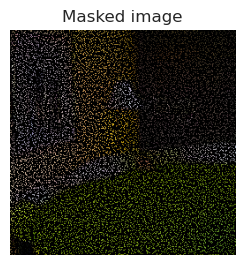

/home/lzh/sde-test-hank-aloha-new-patch-NCU-NCU/controllable_generation.py:458: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  psnr = compare_psnr(255.* rec_psnr_Image, 255. * data_psnr_Image, data_range=255)
/home/lzh/sde-test-hank-aloha-new-patch-NCU-NCU/controllable_generation.py:459: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  ssim = compare_ssim(rec_psnr_Image, data_psnr_Image, data_range=1,multichannel=True)


000000.png  PSNR: 30.14906724918373  SSIM: 0.828252259555982


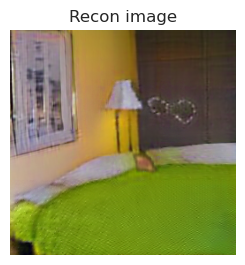

In [5]:
path='./data/test_bedroom_256'



Nimg=64 
Nfir=8   
mu = 10 
muiter = 50

for aaa in sorted(os.listdir(path)):

    file_path = os.path.join(path, aaa)
       
    siat_input=cv2.imread(file_path)
    data = siat_input / 255.
    
    arr = np.ones((256,256))

    mask = io.loadmat('./mask/mask20.mat')['mask']

    mask = mask[:,:,np.newaxis]
    mask = np.concatenate((mask,mask,mask),2)

    print('=====ratio: ', np.sum(mask)/(256*256*3))

    dimg = np.zeros(data.shape).astype(np.float64)
      
    dimg = data*mask  

    plt.figure()
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title('Masked image')
    plt.imshow(dimg[:,:,::-1])
    plt.show()  
    
    Ny,Nx,Nc = dimg.shape
    dimgp,vid,mid,datap = make_dsr_rgb(dimg,Nimg,Nfir,data)

    rimg = aloha_patch_rgb(dimgp,mask,mid,Nimg,Nfir,mu,muiter,datap)
    
    M3 = np.reshape(rimg.T,[rimg.shape[0]*rimg.shape[1]*rimg.shape[2], 1]) 
    recon   = np.reshape(M3[vid],(Ny,Nx,Nc) ,order = 'F')
    recon = recon * ( 1. - mask)  + dimg
    
    #print(recon.shape,recon.max(),recon.min())
    recon = np.clip(recon,0,1)
    
    psnr = compare_psnr(255.* recon, 255. * data, data_range=255)
    ssim = compare_ssim(recon, data, data_range=1,multichannel=True)
    print(aaa, ' PSNR:', psnr,' SSIM:', ssim)

    plt.subplot(1,2,2)
    plt.axis('off')
    plt.title('Recon image')
    plt.imshow(recon[:,:,::-1])
    plt.show()

    # plt.subplot(1,3,3)
    # plt.axis('off')
    # plt.title('Ori image')
    # plt.imshow(data[:,:,::-1])
    # plt.show()

    

    


